# Scenario Reduction

**First Author**: Leonardo Hernán Talero Sarmiento
M.Sc. Industrial Engineering
(ltalero@unab.edu.co)

**Second Author**: Juan David Márquez González
M.Sc.Industrial Engineering

**Third Author**: Henry Lamos Diaz
Ph.D. in Physics and Mathematics


This notebook is an updated version of Juan David Márquez González's thesis work. You can find the repository [here](https://colab.research.google.com/drive/19QxoGpIv1u1R5F4g1Bs4-E-80yYf3zKx#scrollTo=RGNENgRdt1dB). In this model, we optimize the function to calculate and reduce scenarios. Additionally, we conduct a sensitivity analysis of the results using the precipitation time-series retrieved from the [NASA](https://power.larc.nasa.gov/data-access-viewer/) power database as a stochastic parameter.
____
**Version**: 01
**Date**: 23/12/2023

# Outline

# Function

This Python script involves multiple functions geared towards scenario reduction in stochastic optimization or decision-making. It's particularly useful for simplifying models in contexts like finance or logistics, where reducing the number of scenarios can streamline computations without greatly impacting accuracy.

## Function Overview

1. **`norm_matrix(matrix)`**
   - **Purpose:** Normalizes each row of a matrix.
   - **Algorithm:** Subtracts the mean and divides by the standard deviation for each row.
   - **Complexity:** $ O(n \times m) $, where $ n $ is the number of rows and $ m $ the number of columns.

2. **`kantorovich_distance(df)`**
   - **Purpose:** Calculates the Kantorovich distance matrix for a DataFrame.
   - **Details:** Transposes the DataFrame if columns outnumber rows.
   - **Complexity:** $ O(n^2 \times m) $, with pairwise distances between rows.

3. **`initialize_probability_matrix(num_rows, num_scenarios)`**
   - **Purpose:** Creates a probability matrix with a uniform distribution.
   - **Complexity:** $ O(n \times m) $, where $ n $ is rows and $ m $ is scenarios.

4. **`select_scenarios_to_merge(Kan_dis, pi_vector, active_scenarios)`**
   - **Purpose:** Selects two scenarios to merge by minimizing a cost function.
   - **Details:** Cost function considers Kantorovich distance and scenario probabilities.
   - **Complexity:** $ O(n^2) $, where $ n $ is the number of active scenarios.

5. **`merge_scenarios(df, Q, Tol, a)`**
   - **Purpose:** Iteratively merges scenarios based on distances, probabilities, and tolerance.
   - **Details:** Repeats until reaching desired scenario count or no feasible merges.
   - **Complexity:** Worst-case $ O(t \times n^3) $, where $ t $ is time steps and $ n $ is scenarios.

## Inputs, Outputs, Subproblems

- **Inputs:** DataFrames or matrices for scenarios, parameters like `Q`, `Tol`, `a`.
- **Outputs:** Reduced scenarios set, final scenario probabilities, merge history.
- **Subproblems:** Data normalization, distance calculation, scenario selection, probability updates.



## Complexity Analysis 
### 1. `norm_matrix(matrix)`

This function normalizes each row of a matrix by subtracting the mean and dividing by the standard deviation of that row.

- **Complexity Analysis:** 
  - The mean and standard deviation are calculated for each row. Assuming the matrix has `n` rows and `m` columns, calculating the mean and standard deviation for a row takes $O(m)$ operations.
  - This process is repeated for all `n` rows, leading to a total complexity of $O(n \times m)$.

### 2. `kantorovich_distance(df)`

This function calculates the Kantorovich distance (a variation of Euclidean distance) between rows of a DataFrame.

- **Complexity Analysis:** 
  - The function first checks if the DataFrame needs transposing. This check is $O(1)$.
  - `pdist` computes the pairwise distance between rows. For a matrix with `n` rows, there are $\binom{n}{2} = \frac{n \times (n-1)}{2}$ unique pairs of rows. 
  - For each pair, computing the Euclidean distance in an `m`-dimensional space takes $O(m)$ operations.
  - Therefore, the total complexity is $O(\frac{n \times (n-1)}{2} \times m) = O(n^2 \times m)$.

### 3. `initialize_probability_matrix(num_rows, num_scenarios)`

This function initializes a matrix with uniform probabilities.

- **Complexity Analysis:** 
  - The function fills an `n` by `m` matrix with a constant value (1/`num_scenarios`).
  - This operation requires $O(n \times m)$ time, as each of the `n \times m` entries is set once.

### 4. `select_scenarios_to_merge(Kan_dis, pi_vector, active_scenarios)`

This function selects scenarios to merge based on minimizing a cost function.

- **Complexity Analysis:**
  - The function iterates through pairs of scenarios. If there are `n` scenarios, this results in $\binom{n}{2} = \frac{n \times (n-1)}{2}$ pairs.
  - For each pair, it calculates a cost, which involves constant-time operations (accessing elements and arithmetic operations).
  - Thus, the complexity is $O(\frac{n \times (n-1)}{2}) = O(n^2)$.

### 5. `merge_scenarios(df, Q, Tol, a)`

This is the main function for merging scenarios.

- **Complexity Analysis:**
  - The function involves several loops and operations:
    - Normalizing the DataFrame: $O(n \times m)$, as previously discussed.
    - Calculating the Kantorovich distance: $O(n^2 \times m)$.
    - Iterative merging process: 
      - The outer loop runs for a number of iterations proportional to the number of rows `t`.
      - The inner while loop can, in the worst case, run `n` times for each time step.
      - Inside this loop, `select_scenarios_to_merge` is called, which is $O(n^2)$.
    - Therefore, the worst-case complexity can be approximated as $O(t \times n^3)$, considering that the dominant factor in each iteration is the $O(n^2)$ complexity of selecting scenarios to merge.



Sure, let's break down the `merge_scenarios` function into step-by-step pseudocode explanations:

### Step 1: Initialization
```pseudo
IF Tol is None THEN
    SET Tol to 0.2
```
- If a tolerance level (`Tol`) isn't provided, it defaults to 0.2. This parameter will later help determine when to stop merging scenarios.

```pseudo
CALL norm_matrix(df) and STORE in norm_df
CALL kantorovich_distance(norm_df) and STORE in Kan_dis
```
- Normalize the data frame `df` and store the result in `norm_df`.
- Calculate the Kantorovich distance (a measure of similarity) between each pair of scenarios in `norm_df` and store it in `Kan_dis`.

```pseudo
GET the number of rows and scenarios from df and STORE in num_rows, num_scenarios
CALL initialize_probability_matrix(num_rows, num_scenarios) and STORE in pi_matrix
```
- Determine the dimensions of `df` (number of rows and scenarios).
- Initialize a probability matrix `pi_matrix` with equal probabilities for each scenario.

```pseudo
INITIALIZE merge_history as an empty list
INITIALIZE active_scenarios as a list of column names from df
INITIALIZE scenario_probabilities with equal probabilities for each scenario
```
- Prepare an empty list `merge_history` to record the history of merges.
- List all scenarios (columns in `df`) in `active_scenarios`.
- Set up `scenario_probabilities` with an equal initial probability for each scenario.

### Step 2: Iterating Over Each Time Step
```pseudo
FOR each row t in df from last to first DO
    SET scenarios_merged_in_step to False
    WHILE number of active scenarios > minimum(Q, length of Kan_dis) DO
        ...
    END WHILE
END FOR
```
- Iterate over each row (time step) in reverse order.
- Within each iteration, continue merging scenarios as long as the number of active scenarios is above a certain threshold.

### Step 3: Selecting and Merging Scenarios
```pseudo
CALL select_scenarios_to_merge with Kan_dis, pi_matrix, and active_scenarios, STORE results
CALCULATE Tol_rel and T to determine if merging is feasible
IF merging criteria are met THEN
    MERGE selected scenarios and update probabilities and matrices
    APPEND merge details to merge_history
END IF
```
- For each iteration, select the best pair of scenarios to merge based on a cost function.
- Calculate relative tolerance (`Tol_rel`) and compare it with a dynamically adjusted threshold (`T`) to decide if merging should proceed.
- If the criteria are met, merge the selected scenarios, update the probability matrix and the list of active scenarios, and record the merge in `merge_history`.

### Step 4: Finalization
```pseudo
UPDATE final_probabilities using scenario_probabilities for active scenarios
PRINT final debugging information
RETURN active_scenarios' columns, final_probabilities, and merge_history
```
- After all iterations, update the final probabilities of the scenarios that remain.
- Print debugging information for analysis.
- Return the list of remaining scenarios, their final probabilities, and the history of how scenarios were merged.


# Code

In [13]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def norm_matrix(matrix):
    return matrix.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

def kantorovich_distance(df):
    # Transpose the DataFrame if there are more columns than rows
    if df.shape[1] > df.shape[0]:
        df = df.T
    return squareform(pdist(df, 'euclidean'))


def initialize_probability_matrix(num_rows, num_scenarios):
    return np.full((num_rows, num_scenarios), 1.0 / num_scenarios)

def select_scenarios_to_merge(Kan_dis, pi_vector, active_scenarios):
    min_cost = float('inf')
    scenario_to_merge = -1
    E_max = 1

    scenario_index_map = {scenario: index for index, scenario in enumerate(active_scenarios)}

    for i, scenario_i_name in enumerate(active_scenarios):
        for j, scenario_j_name in enumerate(active_scenarios):
            if i != j:
                scenario_i_index = scenario_index_map[scenario_i_name]
                scenario_j_index = scenario_index_map[scenario_j_name]
                cost = Kan_dis[scenario_i_index, scenario_j_index] * pi_vector[scenario_i_index] * pi_vector[scenario_j_index]

                if cost < min_cost:
                    min_cost = cost
                    scenario_to_merge = (i, j)
                    E_max = max(E_max, sum(Kan_dis[scenario_i_index, :]) * pi_vector[scenario_i_index])

    return scenario_to_merge, min_cost, E_max

# The rest of the code remains the same


def merge_scenarios(df, Q, Tol, a):
    if Tol is None:
        Tol = 0.2
    norm_df = norm_matrix(df)
    Kan_dis = kantorovich_distance(norm_df)
    num_rows, num_scenarios = df.shape
    pi_matrix = initialize_probability_matrix(num_rows, num_scenarios)
    merge_history = []
    active_scenarios = df.columns.tolist()
    scenario_probabilities = {scenario: 1.0 / num_scenarios for scenario in df.columns}

    for t in range(num_rows - 1, -1, -1):
        scenarios_merged_in_step = False

        while len(active_scenarios) > min((Q if Q is not None else 1), len(Kan_dis)):
            scenario_to_merge, min_cost, E_max = select_scenarios_to_merge(Kan_dis, pi_matrix[t, :len(active_scenarios)], active_scenarios)
            Tol_rel = min_cost / E_max
            T = Tol / (a ** (num_rows - 1 - t))

            #print(f"Time Step: {t}, Tol_rel: {Tol_rel}, T: {T}")

            if Tol_rel < T and scenario_to_merge != -1:
                scenarios_merged_in_step = True
                merged_scenario_name, closest_scenario_name = [active_scenarios[i] for i in scenario_to_merge]

                pi_matrix[t, scenario_to_merge[1]] += pi_matrix[t, scenario_to_merge[0]]
                pi_matrix[t, scenario_to_merge[0]] = 0

                active_scenarios.remove(merged_scenario_name)
                merge_history.append((merged_scenario_name, closest_scenario_name, t))

                Kan_dis = np.delete(Kan_dis, scenario_to_merge[0], axis=0)
                Kan_dis = np.delete(Kan_dis, scenario_to_merge[0], axis=1)
                pi_matrix = np.delete(pi_matrix, scenario_to_merge[0], axis=1)

                merged_probability = scenario_probabilities.pop(merged_scenario_name)
                scenario_probabilities[closest_scenario_name] += merged_probability

                updated_probabilities = pi_matrix[t, :len(active_scenarios)]
                #print(f"Merging scenarios: {merged_scenario_name} into {closest_scenario_name}, Updated Probabilities: {updated_probabilities}")
                #print("Updated Kantorovich Distance Matrix:")
                #print(np.array2string(Kan_dis, formatter={'float_kind':lambda x: "%.2f" % x}))


                #print(f"Merging scenarios: {merged_scenario_name} into {closest_scenario_name}")
            else:
                #print(f"No feasible merge found at Time Step: {t}, advancing to next timestep")
                break

        if not scenarios_merged_in_step and t < num_rows - 1:
            pi_matrix[t + 1, :len(active_scenarios)] = pi_matrix[t, :len(active_scenarios)]
            print(f"Advancing to Time Step: {t + 1}")

    final_probabilities = [scenario_probabilities[scenario] for scenario in active_scenarios]

    print(f"Debug: Final Probabilities before extraction: {pi_matrix[-1]}")
    print(f"Active Scenarios: {active_scenarios}")
    print(f"Final Columns: {df[active_scenarios].columns}")
    print(f"Final Probabilities: {final_probabilities}")
    print(f"Merge History: {merge_history}")

    return df[active_scenarios].columns, final_probabilities, merge_history


# Examples

We will start by creating an additional function to visualize the data before and after the merge process

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_time_series(df):
    plt.style.use('ggplot')

    # Calculate the mean of each column
    means = df.mean()

    # Normalize the means to [0, 1] for color mapping
    normalized_means = (means - means.min()) / (means.max() - means.min())

    # Create a color palette ranging from green to yellow to red
    colors = sns.color_palette("RdYlGn", len(df.columns))

    # Sort columns by mean values for color assignment
    sorted_columns = means.sort_values().index

    # Plot each column with its corresponding color and added transparency
    for col in sorted_columns:
        plt.plot(df.index, df[col], label=col,
                 color=colors[int(normalized_means[col] * (len(colors) - 1))],
                 alpha=0.4)  # Setting transparency

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Time Series Plot')
    
    plt.show()


## 1. Illustrative example

In [14]:

# Example usage
DATA = pd.DataFrame({
    "s1": [100, 150, 160, 90, 150, 150],
    "s2": [110, 140, 150, 110, 150, 140],
    "s3": [90, 130, 140, 80, 130, 120],
    "s4": [100, 150, 200, 100, 140, 200],
    "s5": [100, 130, 180, 110, 150, 180],
    "s6": [90, 115, 140, 80, 130, 120],
    "s7": [100, 150, 185, 100, 140, 200],
    "s8": [100, 130, 180, 120, 150, 180]
})

Q = None
Tol = .05
a = 1.5
final_columns, final_probs, merge_history = merge_scenarios(DATA, Q, Tol, a)

print("Final Columns:", final_columns)
print("Final Probabilities:", final_probs)
print("Merge History:", merge_history)


Advancing to Time Step: 4
Advancing to Time Step: 3
Advancing to Time Step: 2
Advancing to Time Step: 1
Debug: Final Probabilities before extraction: [0.25 0.25 0.25]
Active Scenarios: ['s2', 's6', 's8']
Final Columns: Index(['s2', 's6', 's8'], dtype='object')
Final Probabilities: [0.25, 0.25, 0.5]
Merge History: [('s4', 's7', 5), ('s5', 's8', 5), ('s3', 's6', 5), ('s1', 's2', 5), ('s7', 's8', 4)]
Final Columns: Index(['s2', 's6', 's8'], dtype='object')
Final Probabilities: [0.25, 0.25, 0.5]
Merge History: [('s4', 's7', 5), ('s5', 's8', 5), ('s3', 's6', 5), ('s1', 's2', 5), ('s7', 's8', 4)]


The merge history reflects a series of steps where individual scenarios were combined into new, merged scenarios. Let's break down the effects of these merges on the probability distribution:

1. **Merge history breakdown**:
   - **('s4', 's7', 5)**: Scenarios s4 and s7 were merged at time step 5. This means that their individual probabilities were combined, reducing the total number of active scenarios by one.
   - **('s5', 's8', 5)**: Similarly, s5 and s8 were merged at the same time step, further consolidating the scenarios and their probabilities.
   - **('s3', 's6', 5)**: Scenarios s3 and s6 were also merged, continuing the trend of combining scenarios based on some criteria, likely the Kantorovich distance in this context.
   - **('s1', 's2', 5)**: Scenarios s1 and s2 were merged, indicating that s2 now carries the probability weight of both s1 and s2.
   - **('s7', 's8', 4)**: In the next time step, the scenario resulting from the merge of s4 and s7 was merged with s8 (which already includes the probability of s5). This results in s8 becoming a more probable scenario due to the accumulation of probabilities from s5, s7, and indirectly from s4.

2. **Effect on probabilities**:
   - At the end of the merging process, we have three active scenarios: s2, s6, and s8.
   - The **final probabilities** of [0.25, 0.25, 0.5] indicate that:
     - Scenario s2, which includes the initial probability of s1 due to the merge, has a final probability of 0.25.
     - Scenario s6, which includes the initial probability of s3, also has a final probability of 0.25.
     - Scenario s8 is the most significant, with a final probability of 0.5. This is because s8 is the result of multiple merges, each time accumulating the probabilities of the merged scenarios. It has effectively become a "super scenario" that is twice as likely as the other active scenarios.

The **debug output** for the final probabilities before extraction confirms that each of the three remaining scenarios has a probability corresponding to its position in the array. The active scenarios are labeled s2, s6, and s8, and their probabilities align with the values provided in the final probabilities array.


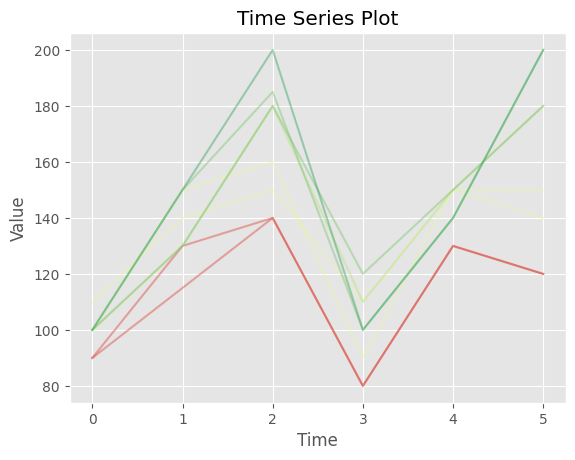

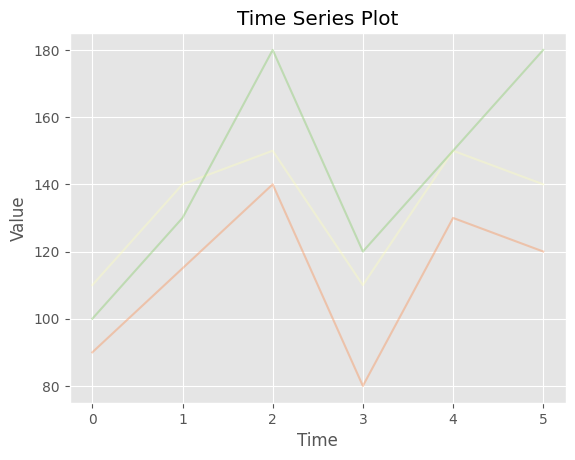

In [16]:
plot_time_series(DATA.head(15))
plot_time_series(DATA[final_columns].head(15))

## 2. Example with random data 

In this example we introduce a random dataset with 180 rows and 500 

In [17]:
import pandas as pd
import numpy as np

# Creating a DataFrame with 180 rows and 500 columns
# Filling it with random data for the purpose of example

np.random.seed(0)  # Seed for reproducibility
rows = 180
columns = 1000
data = np.random.randn(rows, columns)  # Normally distributed data
DATA = pd.DataFrame(data)

Q = None
Tol = .00005
a = 1.5
final_columns, final_probs, merge_history = merge_scenarios(DATA, Q, Tol, a)

Advancing to Time Step: 177
Advancing to Time Step: 176
Advancing to Time Step: 175
Advancing to Time Step: 174
Advancing to Time Step: 173
Advancing to Time Step: 172
Advancing to Time Step: 171
Advancing to Time Step: 170
Advancing to Time Step: 169
Advancing to Time Step: 168
Advancing to Time Step: 167
Advancing to Time Step: 166
Advancing to Time Step: 165
Advancing to Time Step: 164
Advancing to Time Step: 163
Advancing to Time Step: 162
Advancing to Time Step: 161
Advancing to Time Step: 160
Advancing to Time Step: 159
Advancing to Time Step: 158
Advancing to Time Step: 157
Advancing to Time Step: 156
Advancing to Time Step: 155
Advancing to Time Step: 154
Advancing to Time Step: 153
Advancing to Time Step: 152
Advancing to Time Step: 151
Advancing to Time Step: 150
Advancing to Time Step: 149
Advancing to Time Step: 148
Advancing to Time Step: 147
Advancing to Time Step: 146
Advancing to Time Step: 145
Advancing to Time Step: 144
Advancing to Time Step: 143
Advancing to Time St

The algorithm spent two minutes with 28.1 seconds. In this example, we did not indicate the total number of scenarios. The scenario merging process, which aims to reduce complexity by combining similar scenarios, is heavily influenced by the original data's distribution. Given the normal distribution, many scenarios are likely to be close in value, leading to numerous potential mergers that are almost equally viable. This creates a situation where merged scenarios tend to converge towards the dataset's mean. The closeness of the final probabilities indicates a lack of distinct, highly differentiated scenarios in the final set. This is typical when the original scenarios are variations of a central theme or trend (in this case, the mean of the normally distributed data).

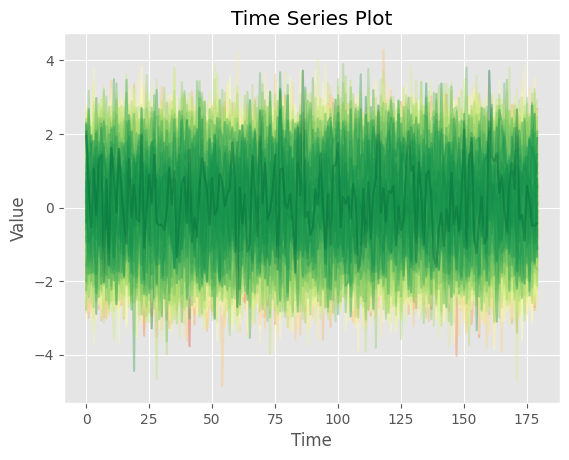

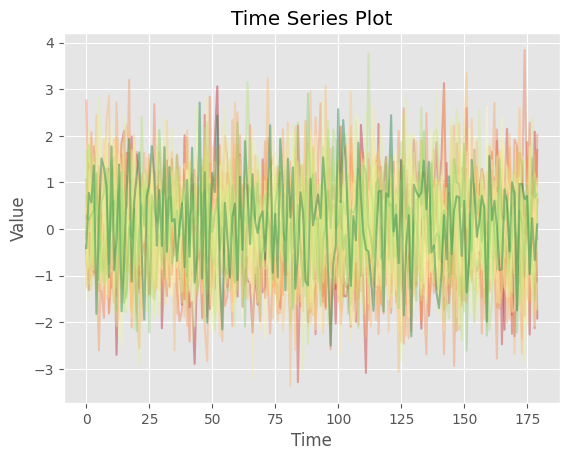

In [19]:
plot_time_series(DATA)
plot_time_series(DATA[final_columns])

## 3. Example with precipitation forecasting data

In this example, we use forecasted data generated with ARIMA models. The main idea is to use data two weeks ahead (in the final implementation). We use 1,000 columns and 15 rows. Finally, we select the final number of scenarios to merge so the tolerance level by default is fixed to 0.2.

In [20]:
DATA = pd.read_csv('/workspaces/TSO/ARMSIM.csv')
DATA.drop('Time',axis=1,inplace=True)
Q = 5
Tol = None
a = 1.5
final_columns, final_probs, merge_history = merge_scenarios(DATA.head(15).iloc[:, :1000], Q, Tol, a)



Advancing to Time Step: 14
Advancing to Time Step: 13
Advancing to Time Step: 12
Advancing to Time Step: 11
Advancing to Time Step: 10
Advancing to Time Step: 9
Advancing to Time Step: 8
Advancing to Time Step: 7
Advancing to Time Step: 6
Advancing to Time Step: 5
Advancing to Time Step: 4
Advancing to Time Step: 3
Advancing to Time Step: 2
Advancing to Time Step: 1
Debug: Final Probabilities before extraction: [0.001 0.001 0.001 0.001 0.001]
Active Scenarios: ['X939', 'X991', 'X993', 'X995', 'X996']
Final Columns: Index(['X939', 'X991', 'X993', 'X995', 'X996'], dtype='object')
Final Probabilities: [0.11699999999999999, 0.063, 0.178, 0.354, 0.288]
Merge History: [('X437', 'X681', 14), ('X235', 'X914', 14), ('X8', 'X245', 14), ('X421', 'X483', 14), ('X258', 'X312', 14), ('X98', 'X672', 14), ('X252', 'X481', 14), ('X710', 'X853', 14), ('X106', 'X755', 14), ('X70', 'X82', 14), ('X589', 'X664', 14), ('X48', 'X182', 14), ('X49', 'X960', 14), ('X198', 'X243', 14), ('X168', 'X841', 14), ('X26

The algorithm spent two minutes and 38 seconds. These probabilities and their associated scenarios can be interpreted as the key patterns the ARIMA model predicts for future precipitation. Each scenario likely encapsulates a specific forecast aspect, such as average rainfall, peak precipitation periods, dry spells, etc. The probabilities in this example are quite different, with values between 6.3% and 35.4%, and their respective data distribution indicate behaviors differently (patterns, peaks, etc.)

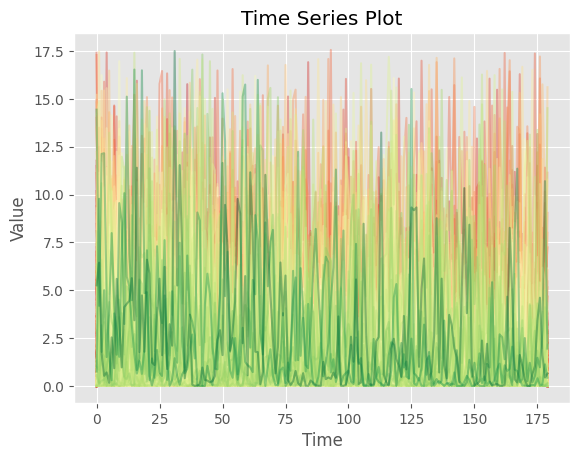

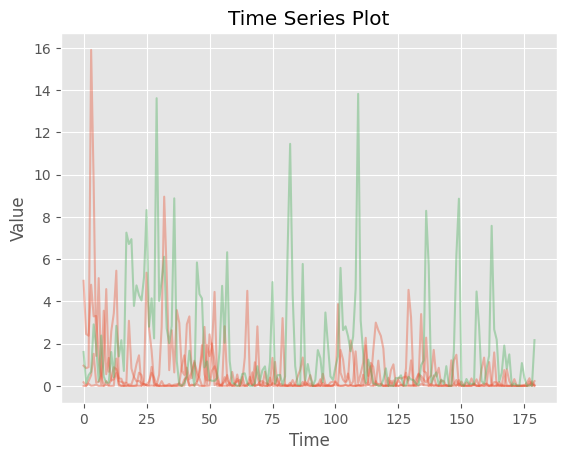

In [21]:
plot_time_series(DATA)
plot_time_series(DATA[final_columns])